# DAY 37

我今天的笔记是用cpu训练的，请自行修改为gpu训练

仍然是循序渐进，先复习之前的代码


使用设备: cpu


训练进度: 100%|██████████| 20000/20000 [00:06<00:00, 3252.53epoch/s, Loss=0.0618]


Training time: 6.15 seconds


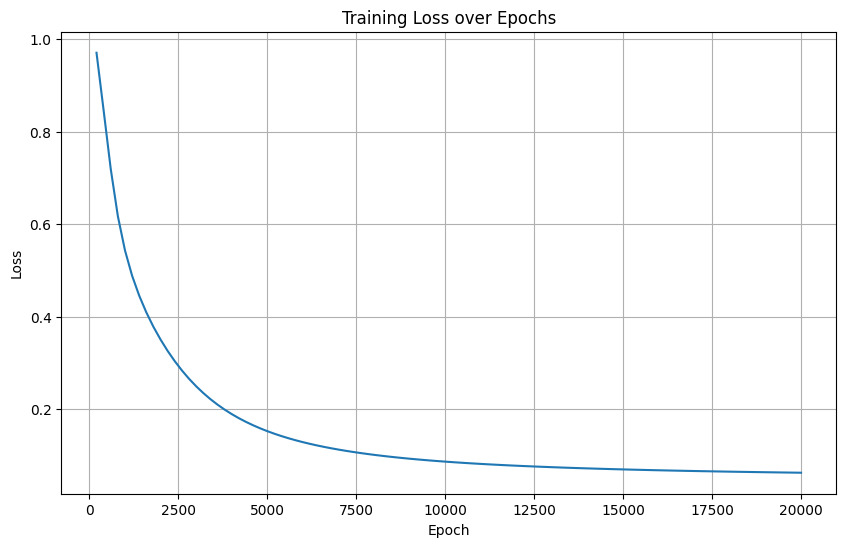

测试集准确率: 96.67%


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import time
import matplotlib.pyplot as plt
from tqdm import tqdm  # 导入tqdm库用于进度条显示
import warnings
warnings.filterwarnings("ignore")  # 忽略警告信息

# 设置GPU设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 加载鸢尾花数据集
iris = load_iris()
X = iris.data  # 特征数据
y = iris.target  # 标签数据

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 归一化数据
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 将数据转换为PyTorch张量并移至GPU
X_train = torch.FloatTensor(X_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_test = torch.LongTensor(y_test).to(device)

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(4, 10)  # 输入层到隐藏层
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(10, 3)  # 隐藏层到输出层

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# 实例化模型并移至GPU
model = MLP().to(device)

# 分类问题使用交叉熵损失函数
criterion = nn.CrossEntropyLoss()

# 使用随机梯度下降优化器
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 训练模型
num_epochs = 20000  # 训练的轮数

# 用于存储每100个epoch的损失值和对应的epoch数
losses = []
epochs = []

start_time = time.time()  # 记录开始时间

# 创建tqdm进度条
with tqdm(total=num_epochs, desc="训练进度", unit="epoch") as pbar:
    # 训练模型
    for epoch in range(num_epochs):
        # 前向传播
        outputs = model(X_train)  # 隐式调用forward函数
        loss = criterion(outputs, y_train)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 记录损失值并更新进度条
        if (epoch + 1) % 200 == 0:
            losses.append(loss.item())
            epochs.append(epoch + 1)
            # 更新进度条的描述信息
            pbar.set_postfix({'Loss': f'{loss.item():.4f}'})

        # 每1000个epoch更新一次进度条
        if (epoch + 1) % 1000 == 0:
            pbar.update(1000)  # 更新进度条

    # 确保进度条达到100%
    if pbar.n < num_epochs:
        pbar.update(num_epochs - pbar.n)  # 计算剩余的进度并更新

time_all = time.time() - start_time  # 计算训练时间
print(f'Training time: {time_all:.2f} seconds')

# 可视化损失曲线
plt.figure(figsize=(10, 6))
plt.plot(epochs, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

# 在测试集上评估模型，此时model内部已经是训练好的参数了
# 评估模型
model.eval() # 设置模型为评估模式
with torch.no_grad(): # torch.no_grad()的作用是禁用梯度计算，可以提高模型推理速度
    outputs = model(X_test)  # 对测试数据进行前向传播，获得预测结果
    _, predicted = torch.max(outputs, 1) # torch.max(outputs, 1)返回每行的最大值和对应的索引
    #这个函数返回2个值，分别是最大值和对应索引，参数1是在第1维度（行）上找最大值，_ 是Python的约定，表示忽略这个返回值，所以这个写法是找到每一行最大值的下标
    # 此时outputs是一个tensor，p每一行是一个样本，每一行有3个值，分别是属于3个类别的概率，取最大值的下标就是预测的类别


    # predicted == y_test判断预测值和真实值是否相等，返回一个tensor，1表示相等，0表示不等，然后求和，再除以y_test.size(0)得到准确率
    # 因为这个时候数据是tensor，所以需要用item()方法将tensor转化为Python的标量
    # 之所以不用sklearn的accuracy_score函数，是因为这个函数是在CPU上运行的，需要将数据转移到CPU上，这样会慢一些
    # size(0)获取第0维的长度，即样本数量

    correct = (predicted == y_test).sum().item() # 计算预测正确的样本数
    accuracy = correct / y_test.size(0)
    print(f'测试集准确率: {accuracy * 100:.2f}%')

训练集的loss在下降，但是有可能出现过拟合现象：模型过度学习了训练集的信息，导致在测试集上表现不理想。

所以很自然的，我们想同步打印测试集的loss，以判断是否出现过拟合现象。

### 过拟合的判断

使用设备: cpu


训练进度: 100%|██████████| 20000/20000 [00:06<00:00, 3245.61epoch/s, Train Loss=0.0633, Test Loss=0.0578]

Training time: 6.16 seconds


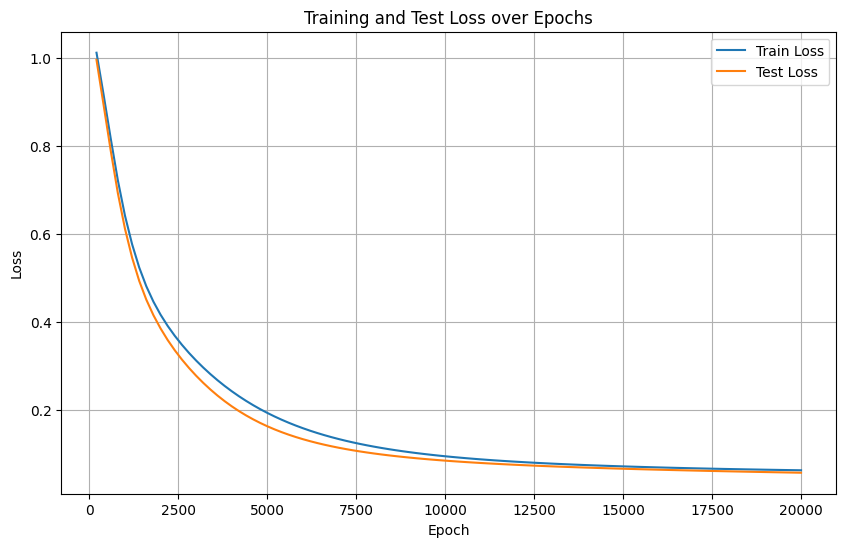

测试集准确率: 96.67%


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import time
import matplotlib.pyplot as plt
from tqdm import tqdm  # 导入tqdm库用于进度条显示
import warnings
warnings.filterwarnings("ignore")  # 忽略警告信息

# 设置GPU设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 加载鸢尾花数据集
iris = load_iris()
X = iris.data  # 特征数据
y = iris.target  # 标签数据

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 归一化数据
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 将数据转换为PyTorch张量并移至GPU
X_train = torch.FloatTensor(X_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_test = torch.LongTensor(y_test).to(device)

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(4, 10)  # 输入层到隐藏层
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(10, 3)  # 隐藏层到输出层

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# 实例化模型并移至GPU
model = MLP().to(device)

# 分类问题使用交叉熵损失函数
criterion = nn.CrossEntropyLoss()

# 使用随机梯度下降优化器
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 训练模型
num_epochs = 20000  # 训练的轮数

# 用于存储每200个epoch的损失值和对应的epoch数
train_losses = [] # 存储训练集损失
test_losses = [] # 新增：存储测试集损失
epochs = []

start_time = time.time()  # 记录开始时间

# 创建tqdm进度条
with tqdm(total=num_epochs, desc="训练进度", unit="epoch") as pbar:
    # 训练模型
    for epoch in range(num_epochs):
        # 前向传播
        outputs = model(X_train)  # 隐式调用forward函数
        train_loss = criterion(outputs, y_train)

        # 反向传播和优化
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # 记录损失值并更新进度条
        if (epoch + 1) % 200 == 0:
            # 计算测试集损失，新增代码
            model.eval()
            with torch.no_grad():
                test_outputs = model(X_test)
                test_loss = criterion(test_outputs, y_test)
            model.train()
            
            train_losses.append(train_loss.item())
            test_losses.append(test_loss.item())
            epochs.append(epoch + 1)
            
            # 更新进度条的描述信息
            pbar.set_postfix({'Train Loss': f'{train_loss.item():.4f}', 'Test Loss': f'{test_loss.item():.4f}'})

        # 每1000个epoch更新一次进度条
        if (epoch + 1) % 1000 == 0:
            pbar.update(1000)  # 更新进度条

    # 确保进度条达到100%
    if pbar.n < num_epochs:
        pbar.update(num_epochs - pbar.n)  # 计算剩余的进度并更新

time_all = time.time() - start_time  # 计算训练时间
print(f'Training time: {time_all:.2f} seconds')

# 可视化损失曲线
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss') # 原始代码已有
plt.plot(epochs, test_losses, label='Test Loss')  # 新增：测试集损失曲线
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend() # 新增：显示图例
plt.grid(True)
plt.show()

# 在测试集上评估模型，此时model内部已经是训练好的参数了
# 评估模型
model.eval() # 设置模型为评估模式
with torch.no_grad(): # torch.no_grad()的作用是禁用梯度计算，可以提高模型推理速度
    outputs = model(X_test)  # 对测试数据进行前向传播，获得预测结果
    _, predicted = torch.max(outputs, 1) # torch.max(outputs, 1)返回每行的最大值和对应的索引
    correct = (predicted == y_test).sum().item() # 计算预测正确的样本数
    accuracy = correct / y_test.size(0)
    print(f'测试集准确率: {accuracy * 100:.2f}%')    

实际上，打印测试集的loss和同步打印测试集的评估指标，是一个逻辑，但是打印loss可以体现在一个图中。

### 模型的保存和加载

深度学习中模型的保存与加载主要涉及参数（权重）和整个模型结构的存储，同时需兼顾训练状态（如优化器参数、轮次等）以支持断点续训。

#### 仅保存模型参数（推荐）

- 原理：保存模型的权重参数，不保存模型结构代码。加载时需提前定义与训练时一致的模型类。
- 优点：文件体积小（仅含参数），跨框架兼容性强（需自行定义模型结构）。

In [13]:
# 保存模型参数
torch.save(model.state_dict(), "model_weights.pth")

In [14]:
# 加载参数（需先定义模型结构）
model = MLP()  # 初始化与训练时相同的模型结构
model.load_state_dict(torch.load("model_weights.pth"))
# model.eval()  # 切换至推理模式（可选）

<All keys matched successfully>

#### 保存模型+权重
- 原理：保存模型结构及参数
- 优点：加载时无需提前定义模型类
- 缺点：文件体积大，依赖训练时的代码环境（如自定义层可能报错）。

In [15]:
# 保存整个模型
torch.save(model, "full_model.pth")

# 加载模型（无需提前定义类，但需确保环境一致）
model = torch.load("full_model.pth")
model.eval()  # 切换至推理模式（可选）

MLP(
  (fc1): Linear(in_features=4, out_features=10, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=10, out_features=3, bias=True)
)

#### 保存训练状态（断点续训）
- 原理：保存模型参数、优化器状态（学习率、动量）、训练轮次、损失值等完整训练状态，用于中断后继续训练。
- 适用场景：长时间训练任务（如分布式训练、算力中断）。

In [ ]:
# # 保存训练状态
# checkpoint = {
#     "model_state_dict": model.state_dict(),
#     "optimizer_state_dict": optimizer.state_dict(),
#     "epoch": epoch,
#     "loss": best_loss,
# }
# torch.save(checkpoint, "checkpoint.pth")

# # 加载并续训
# model = MLP()
# optimizer = torch.optim.Adam(model.parameters())
# checkpoint = torch.load("checkpoint.pth")

# model.load_state_dict(checkpoint["model_state_dict"])
# optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
# start_epoch = checkpoint["epoch"] + 1  # 从下一轮开始训练
# best_loss = checkpoint["loss"]

# # 继续训练循环
# for epoch in range(start_epoch, num_epochs):
#     train(model, optimizer, ...)

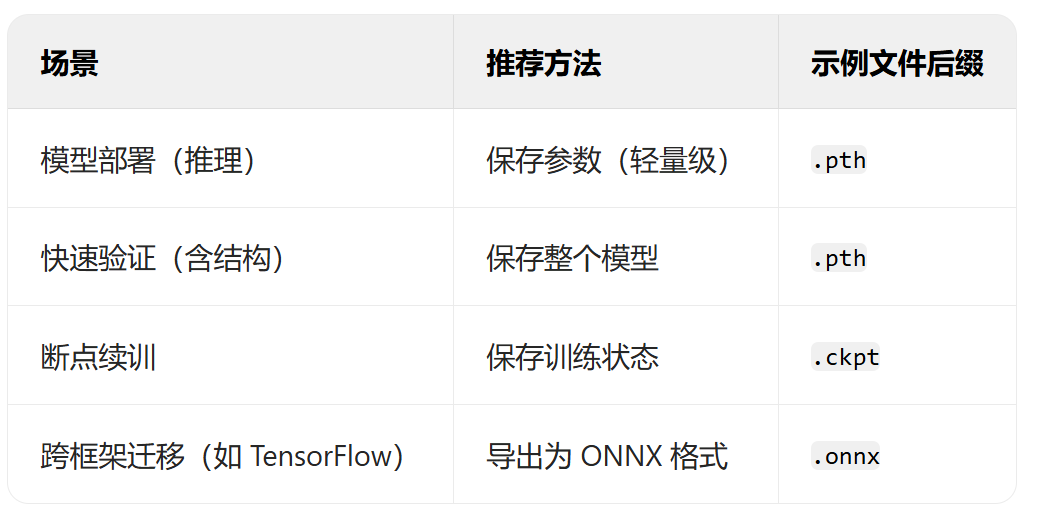

### 早停法(early stop)

我们梳理下过拟合的情况

- 正常情况：训练集和测试集损失同步下降，最终趋于稳定。

- 过拟合：训练集损失持续下降，但测试集损失在某一时刻开始上升（或不再下降）。

如果可以监控验证集的指标不再变好，此时提前终止训练，避免模型对训练集过度拟合。----监控的对象是验证集的指标。这种策略叫早停法。

使用设备: cpu


训练进度: 100%|██████████| 20000/20000 [00:05<00:00, 3387.31epoch/s, Train Loss=0.0607, Test Loss=0.0529]


Training time: 5.91 seconds


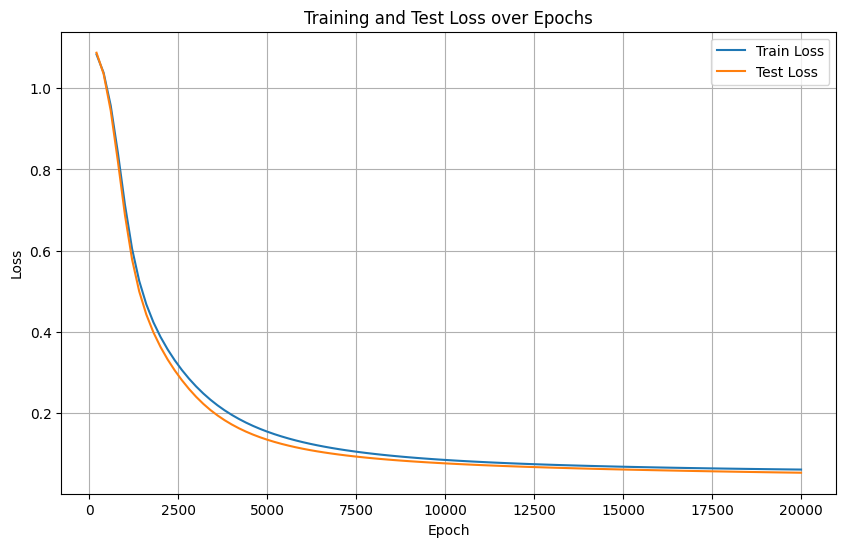

测试集准确率: 96.67%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import time
import matplotlib.pyplot as plt
from tqdm import tqdm  # 导入tqdm库用于进度条显示
import warnings
warnings.filterwarnings("ignore")  # 忽略警告信息

# 设置GPU设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 加载鸢尾花数据集
iris = load_iris()
X = iris.data  # 特征数据
y = iris.target  # 标签数据

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 归一化数据
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 将数据转换为PyTorch张量并移至GPU
X_train = torch.FloatTensor(X_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_test = torch.LongTensor(y_test).to(device)

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(4, 10)  # 输入层到隐藏层
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(10, 3)  # 隐藏层到输出层

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# 实例化模型并移至GPU
model = MLP().to(device)

# 分类问题使用交叉熵损失函数
criterion = nn.CrossEntropyLoss()

# 使用随机梯度下降优化器
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 训练模型
num_epochs = 20000  # 训练的轮数

# 用于存储每200个epoch的损失值和对应的epoch数
train_losses = []  # 存储训练集损失
test_losses = []   # 存储测试集损失
epochs = []

# ===== 新增早停相关参数 =====
best_test_loss = float('inf')  # 记录最佳测试集损失
best_epoch = 0                 # 记录最佳epoch
patience = 50                # 早停耐心值（连续多少轮测试集损失未改善时停止训练）
counter = 0                    # 早停计数器
early_stopped = False          # 是否早停标志
# ==========================

start_time = time.time()  # 记录开始时间

# 创建tqdm进度条
with tqdm(total=num_epochs, desc="训练进度", unit="epoch") as pbar:
    # 训练模型
    for epoch in range(num_epochs):
        # 前向传播
        outputs = model(X_train)  # 隐式调用forward函数
        train_loss = criterion(outputs, y_train)

        # 反向传播和优化
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # 记录损失值并更新进度条
        if (epoch + 1) % 200 == 0:
            # 计算测试集损失
            model.eval()
            with torch.no_grad():
                test_outputs = model(X_test)
                test_loss = criterion(test_outputs, y_test)
            model.train()
            
            train_losses.append(train_loss.item())
            test_losses.append(test_loss.item())
            epochs.append(epoch + 1)
            
            # 更新进度条的描述信息
            pbar.set_postfix({'Train Loss': f'{train_loss.item():.4f}', 'Test Loss': f'{test_loss.item():.4f}'})
            
            # ===== 新增早停逻辑 =====
            if test_loss.item() < best_test_loss: # 如果当前测试集损失小于最佳损失
                best_test_loss = test_loss.item() # 更新最佳损失
                best_epoch = epoch + 1 # 更新最佳epoch
                counter = 0 # 重置计数器
                # 保存最佳模型
                torch.save(model.state_dict(), 'best_model.pth')
            else:
                counter += 1
                if counter >= patience:
                    print(f"早停触发！在第{epoch+1}轮，测试集损失已有{patience}轮未改善。")
                    print(f"最佳测试集损失出现在第{best_epoch}轮，损失值为{best_test_loss:.4f}")
                    early_stopped = True
                    break  # 终止训练循环
            # ======================

        # 每1000个epoch更新一次进度条
        if (epoch + 1) % 1000 == 0:
            pbar.update(1000)  # 更新进度条

    # 确保进度条达到100%
    if pbar.n < num_epochs:
        pbar.update(num_epochs - pbar.n)  # 计算剩余的进度并更新

time_all = time.time() - start_time  # 计算训练时间
print(f'Training time: {time_all:.2f} seconds')

# ===== 新增：加载最佳模型用于最终评估 =====
if early_stopped:
    print(f"加载第{best_epoch}轮的最佳模型进行最终评估...")
    model.load_state_dict(torch.load('best_model.pth'))
# ================================

# 可视化损失曲线
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# 在测试集上评估模型
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == y_test).sum().item()
    accuracy = correct / y_test.size(0)
    print(f'测试集准确率: {accuracy * 100:.2f}%')    

上述早停策略的具体逻辑如下


- 首先初始一个计数器counter。
- 每 200 轮训练执行一次判断：比较当前损失与历史最佳损失。
  - 若当前损失更低，保存模型参数。
  - 若当前损失更高或相等，计数器加 1。
    - 若计数器达到最大容许的阈值patience，则停止训练。

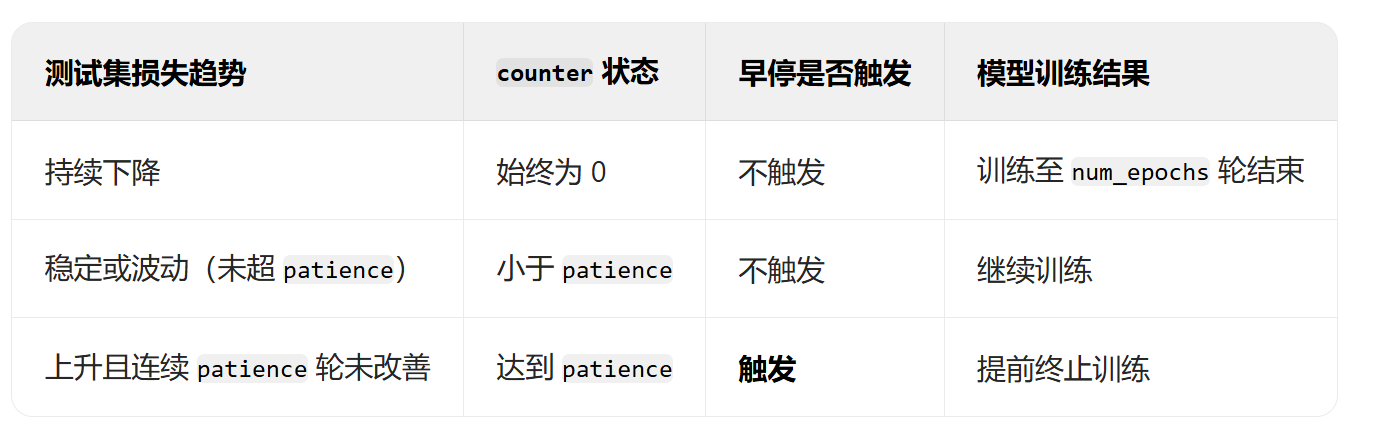

之所以设置阈值patience，是因为训练过程中存在波动，不能完全停止训练。同时每隔固定的训练轮次都会保存模型参数，下次可以接着这里训练，缩小训练的范围。


我这里之所以没有触发早停策略，有以下几个原因：
1. 测试集损失在训练中持续下降或震荡，但未出现连续 patience 轮不改善
2. patience值过大，需要调小




实际上，在早停策略中，保存 checkpoint（检查点） 是更优选择，因为它不仅保存了模型参数，还记录了训练状态（如优化器参数、轮次、损失值等），一但出现了过拟合，方便后续继续训练。

